In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import polars as pl
import pandas as pd
import numpy as np

print("polars version :", pl.__version__)
print("pandas version :", pd.__version__)

# ---- Paths ----
PATH_DEALSCAN  = "/content/drive/MyDrive/loan_pricing_dealscan.csv"
PATH_COMPUSTAT = "/content/drive/MyDrive/as6/COMPUSTAT_funda_annual (1).csv"
PATH_MSF       = "/content/drive/MyDrive/MSF_1996_2023.csv"

# ---- 1) Dealscan (loans) ----
loans = pl.read_csv(
    PATH_DEALSCAN,
    try_parse_dates=True,
    infer_schema_length=2000,
)

# ---- 2) COMPUSTAT:
comp = pl.read_csv(
    PATH_COMPUSTAT,
    try_parse_dates=True,
    infer_schema_length=10000,
    schema_overrides={
        "cusip": pl.Utf8,
    },
)

# ---- 3) MSF:
msf = pl.read_csv(
    PATH_MSF,
    try_parse_dates=True,
    infer_schema_length=10000,
    schema_overrides={
        "RET": pl.Utf8,
        "RETX": pl.Utf8,
        "SICCD": pl.Utf8,
    },
)

print("\n== loan_pricing_dealscan.csv ==")
print("Rows:", loans.height, "| Cols:", loans.width)
print("Columns (first 10):", loans.columns[:10])
print(loans.head(5))

print("\n== COMPUSTAT_funda_annual (1).csv ==")
print("Rows:", comp.height, "| Cols:", comp.width)
print("Columns (first 10):", comp.columns[:10])
print(comp.head(5))

print("\n== MSF_1996_2023.csv ==")
print("Rows:", msf.height, "| Cols:", msf.width)
print("Columns (first 10):", msf.columns[:10])
print(msf.head(5))


Mounted at /content/drive
polars version : 1.31.0
pandas version : 2.2.2

== loan_pricing_dealscan.csv ==
Rows: 160041 | Cols: 70
Columns (first 10): ['gvkey', 'datadate', 'fyear', 'facilityid', 'packageid', 'borrowercompanyid', 'ticker', 'facilitystartdate', 'facilityenddate', 'company']
shape: (5, 70)
┌───────┬────────────┬───────┬────────────┬───┬─────────────────┬────────────────┬────────┬────────┐
│ gvkey ┆ datadate   ┆ fyear ┆ facilityid ┆ … ┆ insuranceprocee ┆ requiredlender ┆ PERMNO ┆ sic    │
│ ---   ┆ ---        ┆ ---   ┆ ---        ┆   ┆ dssweep         ┆ s              ┆ ---    ┆ ---    │
│ i64   ┆ date       ┆ i64   ┆ f64        ┆   ┆ ---             ┆ ---            ┆ i64    ┆ f64    │
│       ┆            ┆       ┆            ┆   ┆ f64             ┆ f64            ┆        ┆        │
╞═══════╪════════════╪═══════╪════════════╪═══╪═════════════════╪════════════════╪════════╪════════╡
│ 1004  ┆ 2015-05-31 ┆ 2014  ┆ 340002.0   ┆ … ┆ null            ┆ 51.0           ┆ 54594 

In [6]:
import polars as pl
import numpy as np

# --------------------------------------------------------
# 1) Helper: industry bucket from SIC  (with pl.lit FIX)
# --------------------------------------------------------
def add_industry_bucket(df, sic_col_name):
    sic = pl.col(sic_col_name).cast(pl.Int64, strict=False)
    return df.with_columns(
        pl.when((sic >=   1) & (sic <=  999)).then(pl.lit("Agric"))
        .when((sic >= 1000) & (sic <= 1499)).then(pl.lit("Mining"))
        .when((sic >= 1500) & (sic <= 1799)).then(pl.lit("Constr"))
        .when((sic >= 2000) & (sic <= 3999)).then(pl.lit("Mfg"))
        .when((sic >= 4000) & (sic <= 4999)).then(pl.lit("TransUtil"))
        .when((sic >= 5000) & (sic <= 5199)).then(pl.lit("Wholesale"))
        .when((sic >= 5200) & (sic <= 5999)).then(pl.lit("Retail"))
        .when((sic >= 6000) & (sic <= 6799)).then(pl.lit("FIRE"))
        .when((sic >= 7000) & (sic <= 8999)).then(pl.lit("Services"))
        .when((sic >= 9000) & (sic <= 9999)).then(pl.lit("PublicAdm"))
        .otherwise(pl.lit("Other"))
        .alias("industry_bucket")
    )

# --------------------------------------------------------
# 2) Dealscan loans — clean & restrict to 1996–2020
# --------------------------------------------------------
loans2 = loans.with_columns([
    pl.col("facilitystartdate").cast(pl.Date),
    pl.col("facilityenddate").cast(pl.Date),
    pl.col("datadate").cast(pl.Date),
])

# Add start-year col
loans2 = loans2.with_columns(
    pl.col("facilitystartdate").dt.year().alias("_year_start")
)

# Industry bucket
if "sic" in loans2.columns:
    loans2 = add_industry_bucket(loans2, "sic")
else:
    loans2 = loans2.with_columns(pl.lit("Unknown").alias("industry_bucket"))

# final restriction
loans_9622 = (
    loans2
    .filter(pl.col("_year_start").is_between(1996, 2020))
    .filter(pl.col("allindrawn").is_not_null())
)

print("== loans_9622 ==")
print("Rows:", loans_9622.height, "| Cols:", loans_9622.width)
print("Facility start dates:",
      loans_9622.select(pl.col("facilitystartdate").min()).item(),
      "→",
      loans_9622.select(pl.col("facilitystartdate").max()).item())
print(loans_9622.select(["gvkey","PERMNO","facilitystartdate","allindrawn","industry_bucket"]).head(5))

# --------------------------------------------------------
# 3) COMPUSTAT clean
# --------------------------------------------------------
comp2 = comp.with_columns([
    pl.col("datadate").cast(pl.Date),
])

if "fyear" in comp2.columns:
    comp2 = comp2.with_columns(pl.col("fyear").alias("year"))
else:
    comp2 = comp2.with_columns(pl.col("datadate").dt.year().alias("year"))

comp_9622 = comp2.filter(pl.col("year").is_between(1996, 2020))

print("\n== comp_9622 ==")
print("Rows:", comp_9622.height, "| Cols:", comp_9622.width)
print("Year range:",
      comp_9622.select(pl.col("year").min()).item(), "→",
      comp_9622.select(pl.col("year").max()).item())
print(comp_9622.select(["gvkey","datadate","year","at","lt","ceq","sale","ni"]).head(5))

# --------------------------------------------------------
# 4) MSF monthly — FIXED FOR POLARS 1.31
# --------------------------------------------------------
msf2 = msf.with_columns([
    pl.col("date").cast(pl.Date),
    pl.col("date").dt.year().alias("year"),
])

# Fix RET and RETX — replaced .str.strip() with .str.strip_chars()
msf2 = msf2.with_columns([
    pl.col("RET").cast(pl.Utf8)
        .str.replace_all(r"[A-Za-z]", "")
        .str.strip_chars()
        .cast(pl.Float64, strict=False)
        .alias("RET_num"),

    pl.col("RETX").cast(pl.Utf8)
        .str.replace_all(r"[A-Za-z]", "")
        .str.strip_chars()
        .cast(pl.Float64, strict=False)
        .alias("RETX_num"),
])

# SICCD to int
msf2 = msf2.with_columns(
    pl.col("SICCD").cast(pl.Int64, strict=False).alias("sic_msf")
)

msf_9622 = msf2.filter(pl.col("year").is_between(1996, 2020))

print("\n== msf_9622 ==")
print("Rows:", msf_9622.height, "| Cols:", msf_9622.width)
print("Year range:",
      msf_9622.select(pl.col("year").min()).item(), "→",
      msf_9622.select(pl.col("year").max()).item())
print(msf_9622.select(["PERMNO","date","year","RET","RET_num","RETX","RETX_num","sic_msf"]).head(5))


== loans_9622 ==
Rows: 150096 | Cols: 72
Facility start dates: 1996-01-02 → 2020-07-01
shape: (5, 5)
┌───────┬────────┬───────────────────┬────────────┬─────────────────┐
│ gvkey ┆ PERMNO ┆ facilitystartdate ┆ allindrawn ┆ industry_bucket │
│ ---   ┆ ---    ┆ ---               ┆ ---        ┆ ---             │
│ i64   ┆ i64    ┆ date              ┆ f64        ┆ str             │
╞═══════╪════════╪═══════════════════╪════════════╪═════════════════╡
│ 1004  ┆ 54594  ┆ 2015-03-24        ┆ 125.0      ┆ Wholesale       │
│ 1004  ┆ 54594  ┆ 2015-03-24        ┆ 125.0      ┆ Wholesale       │
│ 1004  ┆ 54594  ┆ 2015-03-24        ┆ 125.0      ┆ Wholesale       │
│ 1004  ┆ 54594  ┆ 2015-03-24        ┆ 125.0      ┆ Wholesale       │
│ 1004  ┆ 54594  ┆ 2015-03-24        ┆ 125.0      ┆ Wholesale       │
└───────┴────────┴───────────────────┴────────────┴─────────────────┘

== comp_9622 ==
Rows: 273761 | Cols: 982
Year range: 1996 → 2020
shape: (5, 8)
┌───────┬────────────┬──────┬─────────┬─────────┬

In [7]:
# === CELL 3: Sample up to 100 firms per year from loans_9622 ===
import polars as pl

# 1) Core loan slice with a clean firm id
loan_core = (
    loans_9622
    .filter(pl.col("allindrawn").is_not_null())
    .select([
        "gvkey",
        "PERMNO",
        "facilityid",
        "packageid",
        "company",
        "sic",
        "industry_bucket",
        "facilitystartdate",
        "facilityenddate",
        "allindrawn",
        "allinundrawn",
        "facilityamt",
        "maturity",
        "secured",
        "_year_start",
    ])
    .with_columns(
        pl.when(pl.col("gvkey").is_not_null())
          .then(pl.col("gvkey").cast(pl.Utf8))
          .otherwise(pl.col("PERMNO").cast(pl.Utf8))
          .alias("_firm_id")
    )
)

# 2) Firm-year groups
firm_years = (
    loan_core
    .group_by(["_year_start", "_firm_id"])
    .agg(pl.len().alias("n_facilities"))
)

# 3) Sample up to 100 firms per year (reproducible)
rng_seed = 42
sample_frames = []
for year_val in firm_years.select("_year_start").unique().to_series().to_list():
    temp = firm_years.filter(pl.col("_year_start") == year_val)
    n = min(100, temp.height)
    sample_frames.append(
        temp.sample(n=n, with_replacement=False, seed=rng_seed)
    )

sample_keys = pl.concat(sample_frames) if sample_frames else firm_years.head(0)

# 4) Join back to keep only sampled firm-years
loan_sample = loan_core.join(
    sample_keys.select(["_year_start", "_firm_id"]),
    on=["_year_start", "_firm_id"],
    how="inner",
)

# 5) Summary checks
print("=== Loans (raw within window) ===")
print(
    loan_core.select([
        pl.len().alias("rows"),
        pl.n_unique("_firm_id").alias("unique_firms"),
        pl.n_unique("_year_start").alias("years"),
        pl.col("_year_start").min().alias("min_year"),
        pl.col("_year_start").max().alias("max_year"),
    ]).to_pandas()
)

print("\n=== Yearly firm counts (pre-sample, first 10) ===")
print(
    loan_core
    .group_by("_year_start")
    .agg(pl.n_unique("_firm_id").alias("firms"))
    .sort("_year_start")
    .head(10)
    .to_pandas()
)

print("\n=== Yearly firm counts (post-sample, should be ≤100 each) ===")
print(
    loan_sample
    .group_by("_year_start")
    .agg(pl.n_unique("_firm_id").alias("firms"))
    .sort("_year_start")
    .to_pandas()
)

print("\n=== Industry bucket distribution (sampled) ===")
print(
    loan_sample
    .group_by("industry_bucket")
    .agg(pl.len().alias("rows"))
    .sort("rows", descending=True)
    .to_pandas()
)

# 6) Keep as DataFrames for next steps
loan_sample_df = loan_sample
comp_9622_df  = comp_9622
msf_9622_df   = msf_9622

print("\nloan_sample_df head:")
print(loan_sample_df.head(5))

print("\ncomp_9622_df head:")
print(comp_9622_df.select(["gvkey","datadate","year","at","lt","ceq","sale","ni"]).head(5))

print("\nmsf_9622_df head:")
print(msf_9622_df.select(["PERMNO","date","year","RET","RET_num","RETX","RETX_num","sic_msf"]).head(5))


=== Loans (raw within window) ===
     rows  unique_firms  years  min_year  max_year
0  150096          3931     25      1996      2020

=== Yearly firm counts (pre-sample, first 10) ===
   _year_start  firms
0         1996    195
1         1997    291
2         1998    227
3         1999    175
4         2000    220
5         2001    172
6         2002    152
7         2003    122
8         2004    122
9         2005    134

=== Yearly firm counts (post-sample, should be ≤100 each) ===
    _year_start  firms
0          1996    100
1          1997    100
2          1998    100
3          1999    100
4          2000    100
5          2001    100
6          2002    100
7          2003    100
8          2004    100
9          2005    100
10         2006    100
11         2007     98
12         2008    100
13         2009     77
14         2010     79
15         2011    100
16         2012    100
17         2013    100
18         2014    100
19         2015    100
20         2016    100
21

In [10]:
# === CELL 4b: Robust macro construction + final loan_final merge ===
import polars as pl
import pandas as pd
import numpy as np
from pandas_datareader import data as web

# ----------------------------------------------------------------------
# 1) Pull macro data from FRED safely
# ----------------------------------------------------------------------
start, end = "1995-12-31", "2020-12-31"
fred_series = {
    "FEDFUNDS": "FEDFUNDS",
    "T10Y3M":   "T10Y3M",
    "UNRATE":   "UNRATE",
    "VIX":      "VIXCLS",
    "CPI":      "CPIAUCSL",
    "USREC":    "USREC",
}

macro_list = []
for name, code in fred_series.items():
    s = web.DataReader(code, "fred", start, end)
    # Ensure it's a DataFrame with correct column name
    if isinstance(s, pd.Series):
        s = s.to_frame(name=name)
    else:
        s = s.rename(columns={code: name})
    macro_list.append(s)

# Align all on the same DateTimeIndex
macro = pd.concat(macro_list, axis=1)

print("Macro raw head:")
print(macro.head())

# ----------------------------------------------------------------------
# 2) Convert to annual (Y) – AS2 style
# ----------------------------------------------------------------------
years_index = macro.resample("Y").mean().index
macro_annual = pd.DataFrame(index=years_index)

macro_annual["FEDFUNDS"] = macro["FEDFUNDS"].resample("Y").mean()
macro_annual["T10Y3M"]   = macro["T10Y3M"].resample("Y").mean()
macro_annual["UNRATE"]   = macro["UNRATE"].resample("Y").mean()
macro_annual["VIX"]      = macro["VIX"].resample("Y").mean()
macro_annual["INF_YOY"]  = macro["CPI"].resample("Y").mean().pct_change()
macro_annual["USREC_Y"]  = macro["USREC"].resample("Y").max()

macro_annual["start_year"] = macro_annual.index.year
macro_annual = macro_annual[(macro_annual["start_year"] >= 1996) & (macro_annual["start_year"] <= 2020)]

print("\nMacro annual head:")
print(macro_annual.head())

# Convert to Polars for joining
macro_pl = pl.from_pandas(macro_annual.reset_index(drop=True))

# ----------------------------------------------------------------------
# 3) Merge Loans + Compustat + CRSP + Macro
# ----------------------------------------------------------------------
# 3a) Loan + Compustat
loan_w_year = loan_sample_df.with_columns(
    pl.col("facilitystartdate").dt.year().alias("start_year")
)

loan_comp = loan_w_year.join(
    comp_feat,
    left_on=["gvkey", "start_year"],
    right_on=["gvkey", "year"],
    how="left",
)

# 3b) Add CRSP features
loan_comp_crsp = loan_comp.join(
    msf_feat,
    left_on=["PERMNO", "start_year"],
    right_on=["PERMNO", "year"],
    how="left",
)

# 3c) Add macro features
loan_final = loan_comp_crsp.join(
    macro_pl,
    on="start_year",
    how="left",
)

# ----------------------------------------------------------------------
# 4) Quick summary & preview
# ----------------------------------------------------------------------
print("\n=== Final merged dataset (loan_final) ===")
print("Rows:", loan_final.height, "Cols:", loan_final.width)

print("\nMissingness summary:")
null_summary = loan_final.select([
    pl.len().alias("rows"),
    pl.col("lev_at").is_null().sum().alias("miss_lev"),
    pl.col("roa").is_null().sum().alias("miss_roa"),
    pl.col("asset_turnover").is_null().sum().alias("miss_aturn"),
    pl.col("avg_ret").is_null().sum().alias("miss_avg_ret"),
    pl.col("volatility").is_null().sum().alias("miss_vol"),
    pl.col("beta_proxy").is_null().sum().alias("miss_beta"),
    pl.col("FEDFUNDS").is_null().sum().alias("miss_fed"),
])
print(null_summary.to_pandas())


print("\nPreview (first 10 rows):")
print(
    loan_final
    .select([
        "gvkey","PERMNO","facilityid","facilityamt","maturity","secured","industry_bucket",
        "start_year",
        "lev_at","roa","asset_turnover","ln_assets",
        "avg_ret","volatility","beta_proxy",
        "FEDFUNDS","T10Y3M","UNRATE","VIX","INF_YOY","USREC_Y",
        "allindrawn","allinundrawn",
    ])
    .head(10)
)


Macro raw head:
            FEDFUNDS  T10Y3M  UNRATE    VIX    CPI  USREC
DATE                                                     
1996-01-01      5.56     NaN     5.6    NaN  154.7    0.0
1996-01-02       NaN    0.40     NaN  12.19    NaN    NaN
1996-01-03       NaN    0.38     NaN  12.10    NaN    NaN
1996-01-04       NaN    0.46     NaN  13.78    NaN    NaN
1996-01-05       NaN    0.50     NaN  13.58    NaN    NaN

Macro annual head:
            FEDFUNDS    T10Y3M    UNRATE        VIX   INF_YOY  USREC_Y  \
DATE                                                                     
1996-12-31  5.298333  1.297937  5.408333  16.442165       NaN      0.0   
1997-12-31  5.460000  1.152520  4.941667  22.363984  0.023376      0.0   
1998-12-31  5.353333  0.355920  4.500000  25.602976  0.015470      0.0   
1999-12-31  4.970000  0.868526  4.216667  24.372976  0.021931      0.0   
2000-12-31  6.235833  0.030359  3.966667  23.315000  0.033667      0.0   

            start_year  
DATE          

/tmp/ipython-input-2407873067.py:39: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  years_index = macro.resample("Y").mean().index
/tmp/ipython-input-2407873067.py:42: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  macro_annual["FEDFUNDS"] = macro["FEDFUNDS"].resample("Y").mean()
/tmp/ipython-input-2407873067.py:43: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  macro_annual["T10Y3M"]   = macro["T10Y3M"].resample("Y").mean()
/tmp/ipython-input-2407873067.py:44: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  macro_annual["UNRATE"]   = macro["UNRATE"].resample("Y").mean()
/tmp/ipython-input-2407873067.py:45: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  macro_annual["VIX"]      = macro["VIX"].resample("Y").mean()
/tmp/ipy


=== Final merged dataset (loan_final) ===
Rows: 46266 Cols: 35

Missingness summary:
    rows  miss_lev  miss_roa  miss_aturn  miss_avg_ret  miss_vol  miss_beta  \
0  46266       965      6462        6462         12737     12989      12989   

   miss_fed  
0         0  

Preview (first 10 rows):
shape: (10, 23)
┌───────┬────────┬────────────┬─────────────┬───┬──────────┬─────────┬────────────┬──────────────┐
│ gvkey ┆ PERMNO ┆ facilityid ┆ facilityamt ┆ … ┆ INF_YOY  ┆ USREC_Y ┆ allindrawn ┆ allinundrawn │
│ ---   ┆ ---    ┆ ---        ┆ ---         ┆   ┆ ---      ┆ ---     ┆ ---        ┆ ---          │
│ i64   ┆ i64    ┆ f64        ┆ f64         ┆   ┆ f64      ┆ f64     ┆ f64        ┆ f64          │
╞═══════╪════════╪════════════╪═════════════╪═══╪══════════╪═════════╪════════════╪══════════════╡
│ 1021  ┆ 10218  ┆ 126674.0   ┆ 3.5e6       ┆ … ┆ 0.028166 ┆ 1.0     ┆ 555.0      ┆ 125.0        │
│ 1021  ┆ 10218  ┆ 126674.0   ┆ 3.5e6       ┆ … ┆ 0.028166 ┆ 1.0     ┆ 555.0      ┆ 125.0  

In [12]:
# === CELL A (FIXED): Build modeling dataset & train/test splits ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 1) Convert Polars -> pandas
loan_pdf = loan_final.to_pandas()

# 2) Keep only rows with valid target & key predictors
model_df = loan_pdf[
    loan_pdf["allindrawn"].notna() &
    loan_pdf["facilityamt"].notna() &
    loan_pdf["maturity"].notna()
].copy()

print("Model df rows (after basic NA filter):", len(model_df))

# 3) Categorical cleanup
model_df["industry_bucket"] = model_df["industry_bucket"].astype("category")
model_df["secured"] = model_df["secured"].fillna("Missing").astype("category")

# 4) Feature lists (compact but representative)
num_cols = [
    "lev_at", "roa", "asset_turnover", "ln_assets",        # firm fundamentals
    "avg_ret", "volatility", "beta_proxy",                 # market view
    "facilityamt", "maturity",                             # loan terms
    "FEDFUNDS", "T10Y3M", "UNRATE", "VIX", "INF_YOY", "USREC_Y"  # macro
]
cat_cols = ["industry_bucket", "secured"]

# 5) Numeric cleaning: remove ±inf, then median-impute
for c in num_cols:
    if c in model_df.columns:
        col = pd.to_numeric(model_df[c], errors="coerce")
        # replace ±inf with NaN
        col = col.replace([np.inf, -np.inf], np.nan)
        med = np.nanmedian(col.values)
        model_df[c] = col.fillna(med)
    else:
        print(f"WARNING: {c} not in model_df; will be dropped.")

# Drop any numeric columns that truly don't exist
num_cols = [c for c in num_cols if c in model_df.columns]

# 6) Define X and y (log target)
feature_cols = num_cols + cat_cols
X = model_df[feature_cols].copy()
y = model_df["allindrawn"].astype(float).values
y_log = np.log1p(y)

# 7) Train/test split
X_train, X_test, y_train, y_test, y_train_log, y_test_log = train_test_split(
    X, y, y_log, test_size=0.2, random_state=42
)

print("Train/Test shapes:")
print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("y_train:", y_train.shape, "| y_test:", y_test.shape)

# 8) Ensure categoricals are properly typed for tree models
for c in cat_cols:
    X_train[c] = X_train[c].astype("category")
    X_test[c] = X_test[c].astype("category")

# 9) Extra safety: remove any remaining ±inf in numeric columns in X_train/X_test
for df in (X_train, X_test):
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df[c] = df[c].replace([np.inf, -np.inf], np.nan)

# 10) Preprocessor for linear / KNN / MLP models (scale + one-hot)
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ]
)

X_train_lin = preprocess.fit_transform(X_train)
X_test_lin  = preprocess.transform(X_test)

print("\nTransformed (linear) shapes:")
print("X_train_lin:", X_train_lin.shape, "| X_test_lin:", X_test_lin.shape)

# We now have:
# - X_train, X_test (pandas with categories)  -> tree models
# - X_train_lin, X_test_lin (numpy/scipy)     -> LASSO, KNN, MLP
# - y_train, y_test (levels)
# - y_train_log, y_test_log (log targets)


Model df rows (after basic NA filter): 46230
Train/Test shapes:
X_train: (36984, 17) | X_test: (9246, 17)
y_train: (36984,) | y_test: (9246,)

Transformed (linear) shapes:
X_train_lin: (36984, 28) | X_test_lin: (9246, 28)


In [13]:
# === CELL B: Train LASSO, XGBoost, LightGBM, KNN (all log-target) ===
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr

import xgboost as xgb
import lightgbm as lgb

# ---------- Helper for evaluation ----------
def eval_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(
        np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))
    ) * 100
    rho = spearmanr(y_true, y_pred).correlation
    print(f"{name:12s} | R²={r2:6.3f} | RMSE={rmse:8.2f} | MAE={mae:8.2f} | MAPE={mape:6.2f}% | ρ={rho:5.3f}")
    return {"Model": name, "R2": r2, "RMSE": rmse, "MAE": mae, "MAPE_pct": mape, "rho": rho}

results = []

# ---------- 1) LASSO on scaled + one-hot features ----------
lasso = LassoCV(
    alphas=None,
    cv=5,
    random_state=42,
    n_jobs=-1,
    max_iter=5000,
)
lasso.fit(X_train_lin, y_train_log)
pred_lasso_log = lasso.predict(X_test_lin)
pred_lasso = np.expm1(pred_lasso_log)
results.append(eval_model("LASSO (log)", y_test, pred_lasso))

# ---------- 2) KNN on scaled + one-hot features ----------
knn = KNeighborsRegressor(
    n_neighbors=25,
    weights="distance",
    metric="minkowski",
)
knn.fit(X_train_lin, y_train_log)
pred_knn_log = knn.predict(X_test_lin)
pred_knn = np.expm1(pred_knn_log)
results.append(eval_model("KNN (log)", y_test, pred_knn))

# ---------- 3) XGBoost on raw numeric + categorical features ----------
# X_train / X_test are pandas DataFrames with category dtypes for cat_cols
xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=400,
    reg_lambda=1.0,
    reg_alpha=0.0,
    enable_categorical=True,
    random_state=42,
    n_jobs=-1,
)
xgb_reg.fit(X_train, y_train_log)
pred_xgb_log = xgb_reg.predict(X_test)
pred_xgb = np.expm1(pred_xgb_log)
results.append(eval_model("XGBoost (log)", y_test, pred_xgb))

# ---------- 4) LightGBM on raw numeric + categorical features ----------
lgb_reg = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=600,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

lgb_reg.fit(
    X_train,
    y_train_log,
    categorical_feature=["industry_bucket", "secured"],
)
pred_lgb_log = lgb_reg.predict(X_test)
pred_lgb = np.expm1(pred_lgb_log)
results.append(eval_model("LightGBM (log)", y_test, pred_lgb))

# ---------- 5) Compare with your PyTorch MLP (if still in memory) ----------
try:
    _ = pred_main  # from your PyTorch MLP+aux earlier
    results.append(eval_model("MLP+aux", y_test, pred_main))
except NameError:
    print("\n[Note] PyTorch MLP+aux predictions not found in this runtime.")

# ---------- 6) Summary table ----------
results_df = pd.DataFrame(results).sort_values("R2", ascending=False)
print("\n=== Model Comparison (log-target back to level) ===")
print(results_df)


LASSO (log)  | R²= 0.086 | RMSE=   99.50 | MAE=   58.21 | MAPE= 44.13% | ρ=0.661
KNN (log)    | R²= 0.992 | RMSE=    9.07 | MAE=    0.37 | MAPE=  0.17% | ρ=0.997
XGBoost (log) | R²= 0.887 | RMSE=   34.97 | MAE=   21.20 | MAPE= 12.28% | ρ=0.951
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2223
[LightGBM] [Info] Number of data points in the train set: 36984, number of used features: 17
[LightGBM] [Info] Start training from score 5.006482
LightGBM (log) | R²= 0.986 | RMSE=   12.48 | MAE=    4.34 | MAPE=  2.36% | ρ=0.995

[Note] PyTorch MLP+aux predictions not found in this runtime.

=== Model Comparison (log-target back to level) ===
            Model        R2       RMSE        MAE   MAPE_pct       rho
1       KNN (log)  0.992416   9.065089   0.367909   0.166280  0.997048
3  LightGBM (log)  0.985618  12.483708   4.336734   2.359187  0.994775
2 

In [16]:
# === CELL C (self-contained): Baseline + LightGBM + decile error table ===
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr
from lightgbm import LGBMRegressor

# Assumes from previous cells:
# X_train, X_test, y_train, y_test, y_train_log

# 0) Train LightGBM here if not already trained in this runtime
try:
    lgb_model
except NameError:
    lgb_model = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )
    lgb_model.fit(X_train, y_train_log)

# 1) LightGBM predictions (trained on log(1 + y))
lgb_pred_log = lgb_model.predict(X_test)
lgb_pred_lev = np.expm1(lgb_pred_log)

# 2) Baseline: constant = mean(train log y), then back-transform
baseline_log = np.full_like(y_test, fill_value=y_train_log.mean(), dtype=float)
baseline_lev = np.expm1(baseline_log)

def eval_metrics(y_true, y_pred, name):
    r2   = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(
        np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))
    ) * 100
    # Spearman (handle constant predictor gracefully)
    try:
        rho = spearmanr(y_true, y_pred).correlation
    except Exception:
        rho = np.nan
    print(f"{name:12s} | R²={r2:7.3f} | RMSE={rmse:8.2f} | MAE={mae:8.2f} | MAPE={mape:6.2f}% | ρ={rho:5.3f}")
    return r2, rmse, mae, mape, rho

print("=== Baseline vs LightGBM (level space) ===")
base_metrics = eval_metrics(y_test, baseline_lev, "Baseline")
lgb_metrics  = eval_metrics(y_test, lgb_pred_lev, "LightGBM")

# 3) Decile-level error table for LightGBM
df_dec = pd.DataFrame({
    "y_true": y_test,
    "y_pred": lgb_pred_lev,
})
# deciles based on actual spread
df_dec["decile"] = pd.qcut(df_dec["y_true"], 10, labels=False, duplicates="drop")

df_dec["abs_err"] = (df_dec["y_true"] - df_dec["y_pred"]).abs()
df_dec["ape"]     = df_dec["abs_err"] / df_dec["y_true"].abs().clip(1e-6)

decile_summary = (
    df_dec
    .groupby("decile")
    .agg(
        count       = ("y_true", "size"),
        mean_actual = ("y_true", "mean"),
        mean_pred   = ("y_pred", "mean"),
        MAE         = ("abs_err", "mean"),
        MedAE       = ("abs_err", "median"),
        MAPE_pct    = ("ape", lambda x: np.mean(x) * 100),
    )
    .reset_index()
)

print("\n=== Decile-level Error Summary (LightGBM) ===")
print(decile_summary)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2223
[LightGBM] [Info] Number of data points in the train set: 36984, number of used features: 17
[LightGBM] [Info] Start training from score 5.006482
=== Baseline vs LightGBM (level space) ===
Baseline     | R²= -0.078 | RMSE=  108.06 | MAE=   73.75 | MAPE= 64.99% | ρ=  nan
LightGBM     | R²=  0.939 | RMSE=   25.69 | MAE=   14.05 | MAPE=  7.82% | ρ=0.977

=== Decile-level Error Summary (LightGBM) ===
   decile  count  mean_actual   mean_pred        MAE      MedAE   MAPE_pct
0       0   1143    49.135456   52.910047   4.832132   2.458228  10.021769
1       1    875    95.389511  102.880901   9.577253   6.335228  10.141911
2       2   1496   119.951537  123.399558   8.137717   6.267203   6.768618
3       3    310   134.884387  137.409856   8.004583   5.918911   5.919663
4       4   1092   149.521520

/tmp/ipython-input-3307402614.py:43: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = spearmanr(y_true, y_pred).correlation


In [17]:
# === CELL D: Simple PyTorch MLP on log-ALLINDRAWN ===
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr

torch.manual_seed(42)

# 1) Prepare tensors
Xtr_t = torch.tensor(X_train_lin.toarray() if hasattr(X_train_lin, "toarray") else X_train_lin,
                     dtype=torch.float32)
Xte_t = torch.tensor(X_test_lin.toarray() if hasattr(X_test_lin, "toarray") else X_test_lin,
                     dtype=torch.float32)

ytr_log_t = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)
yte        = y_test  # numpy array in level space

train_ds = TensorDataset(Xtr_t, ytr_log_t)

batch_size = 256
train_dl   = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# 2) Define a simple MLP
class MLP1(nn.Module):
    def __init__(self, d_in, drop=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 128), nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlp = MLP1(Xtr_t.shape[1]).to(device)

# 3) Training setup
opt  = torch.optim.Adam(model_mlp.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 80
for ep in range(1, epochs+1):
    model_mlp.train()
    running = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model_mlp(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        running += loss.item() * xb.size(0)
    if ep % 10 == 0 or ep == 1:
        print(f"Epoch {ep:3d} | train MSE={running/len(train_ds):.4f}")

# 4) Predict on test, back-transform, compute metrics
model_mlp.eval()
with torch.no_grad():
    y_pred_log = model_mlp(Xte_t.to(device)).cpu().numpy().ravel()
y_pred_lev = np.expm1(y_pred_log)

def mlp_report(y_true, y_pred, name="MLP (log)"):
    r2   = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100
    rho  = spearmanr(y_true, y_pred).correlation
    print(f"{name:10s} | R²={r2:7.3f} | RMSE={rmse:8.2f} | MAE={mae:8.2f} | MAPE={mape:6.2f}% | ρ={rho:5.3f}")
    return r2, rmse, mae, mape, rho

print("\n=== PyTorch MLP on log-spread (TEST) ===")
mlp_metrics = mlp_report(yte, y_pred_lev)


Epoch   1 | train MSE=4.4227
Epoch  10 | train MSE=0.3680
Epoch  20 | train MSE=0.2944
Epoch  30 | train MSE=0.2478
Epoch  40 | train MSE=0.2099
Epoch  50 | train MSE=0.1709
Epoch  60 | train MSE=0.1351
Epoch  70 | train MSE=0.1084
Epoch  80 | train MSE=0.0907

=== PyTorch MLP on log-spread (TEST) ===
MLP (log)  | R²=  0.748 | RMSE=   52.28 | MAE=   30.68 | MAPE= 16.93% | ρ=0.907


In [19]:
# === CELL: Correlation matrices using Pandas (loan_final is Polars) ===

import numpy as np
import pandas as pd

# --- Convert Polars DF to Pandas ---
loan_final_pd = loan_final.to_pandas()

print("Converted loan_final to Pandas:", loan_final_pd.shape)

# --- Select numeric columns ---
numeric_cols = loan_final_pd.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID columns
drop_cols = ["gvkey", "PERMNO", "facilityid", "packageid", "year"]
numeric_cols = [c for c in numeric_cols if c not in drop_cols and c in loan_final_pd.columns]

# --- Keep only numeric subset ---
corr_df = loan_final_pd[numeric_cols].copy()

# --- Drop rows with missing numeric data ---
corr_df = corr_df.dropna()
print("Correlation computed on rows:", corr_df.shape)

# --- Compute full-sample correlation matrix ---
corr_full = corr_df.corr()

# --- Expansion vs Recession subsets ---
expansion_df = corr_df[loan_final_pd["USREC_Y"] == 0]
recession_df = corr_df[loan_final_pd["USREC_Y"] == 1]

corr_expansion = expansion_df.corr()
corr_recession = recession_df.corr()

# --- Display first few rows ---
print("\n=== Full Correlation Matrix (first 10 rows) ===")
print(corr_full.head(10))

print("\n=== Expansion Correlation Matrix (first 10 rows) ===")
print(corr_expansion.head(10))

print("\n=== Recession Correlation Matrix (first 10 rows) ===")
print(corr_recession.head(10))


Converted loan_final to Pandas: (46266, 35)
Correlation computed on rows: (28870, 25)

=== Full Correlation Matrix (first 10 rows) ===
                   sic  allindrawn  allinundrawn  facilityamt  maturity  \
sic           1.000000    0.046073     -0.025297    -0.055646 -0.109132   
allindrawn    0.046073    1.000000      0.657354    -0.293077 -0.178557   
allinundrawn -0.025297    0.657354      1.000000    -0.258700 -0.033819   
facilityamt  -0.055646   -0.293077     -0.258700     1.000000  0.074081   
maturity     -0.109132   -0.178557     -0.033819     0.074081  1.000000   
_year_start  -0.035878   -0.133964     -0.194053     0.298106  0.211867   
start_year   -0.035878   -0.133964     -0.194053     0.298106  0.211867   
at            0.102203   -0.103299     -0.099639     0.206683 -0.014249   
lt            0.095895   -0.089179     -0.085926     0.179097 -0.015968   
ceq           0.114827   -0.162333     -0.158088     0.316651 -0.000312   

              _year_start  start_year  

/tmp/ipython-input-3129929660.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  expansion_df = corr_df[loan_final_pd["USREC_Y"] == 0]
/tmp/ipython-input-3129929660.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  recession_df = corr_df[loan_final_pd["USREC_Y"] == 1]


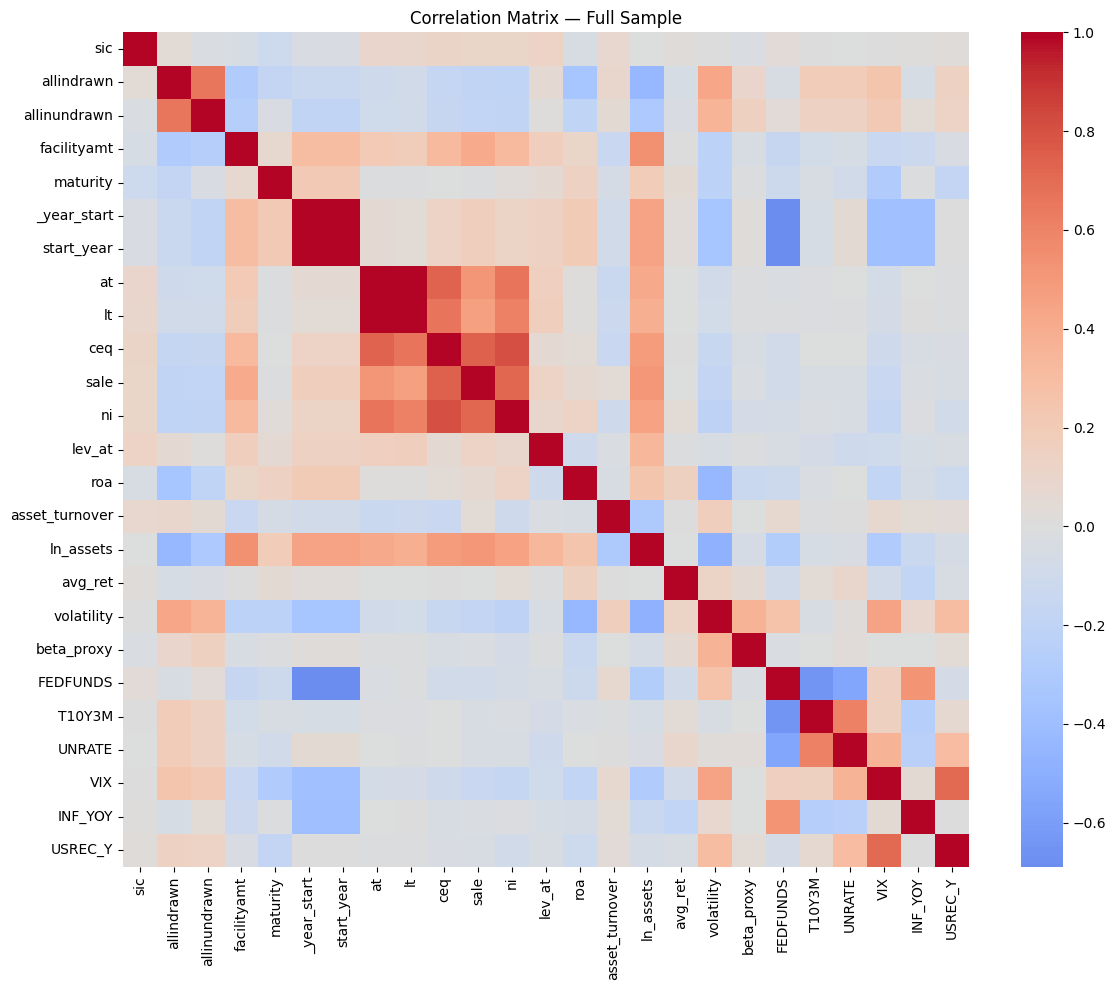

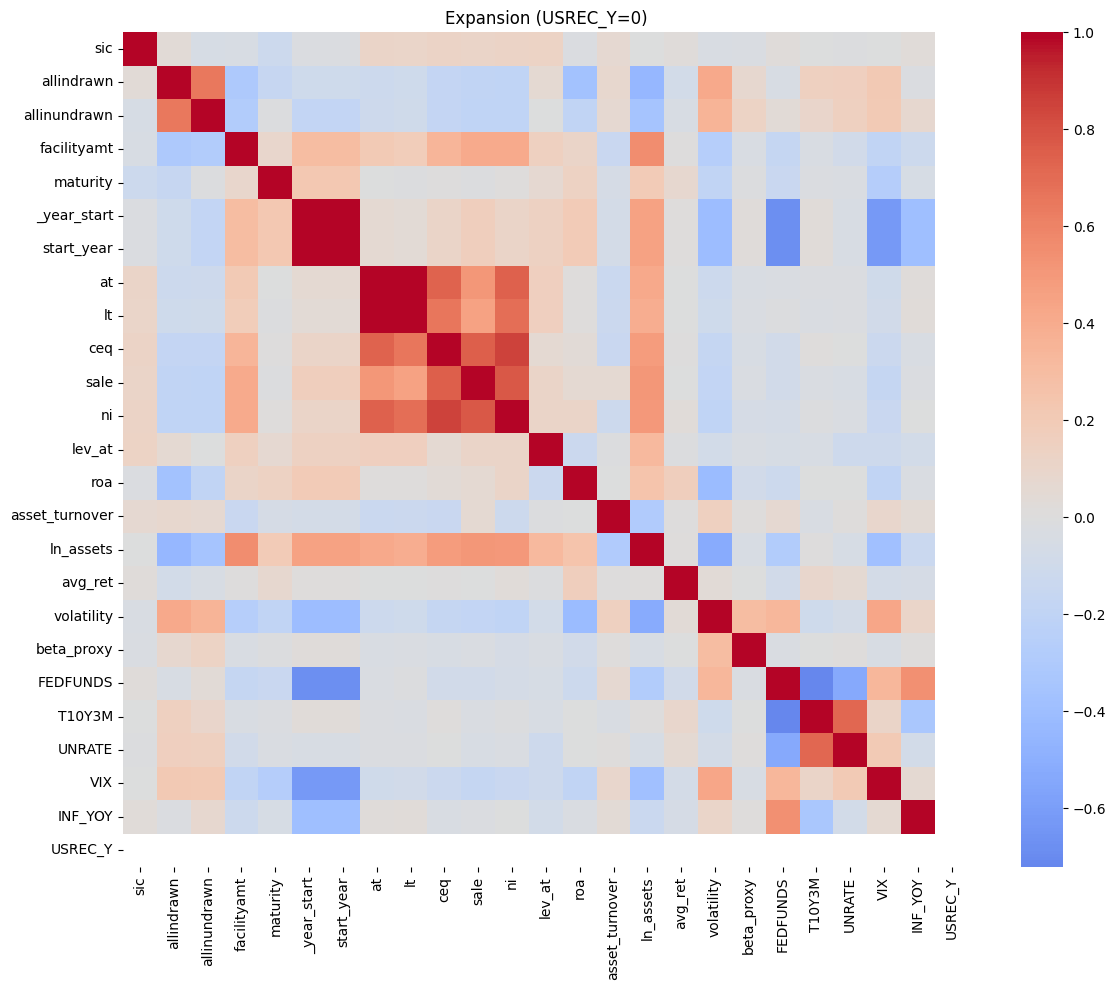

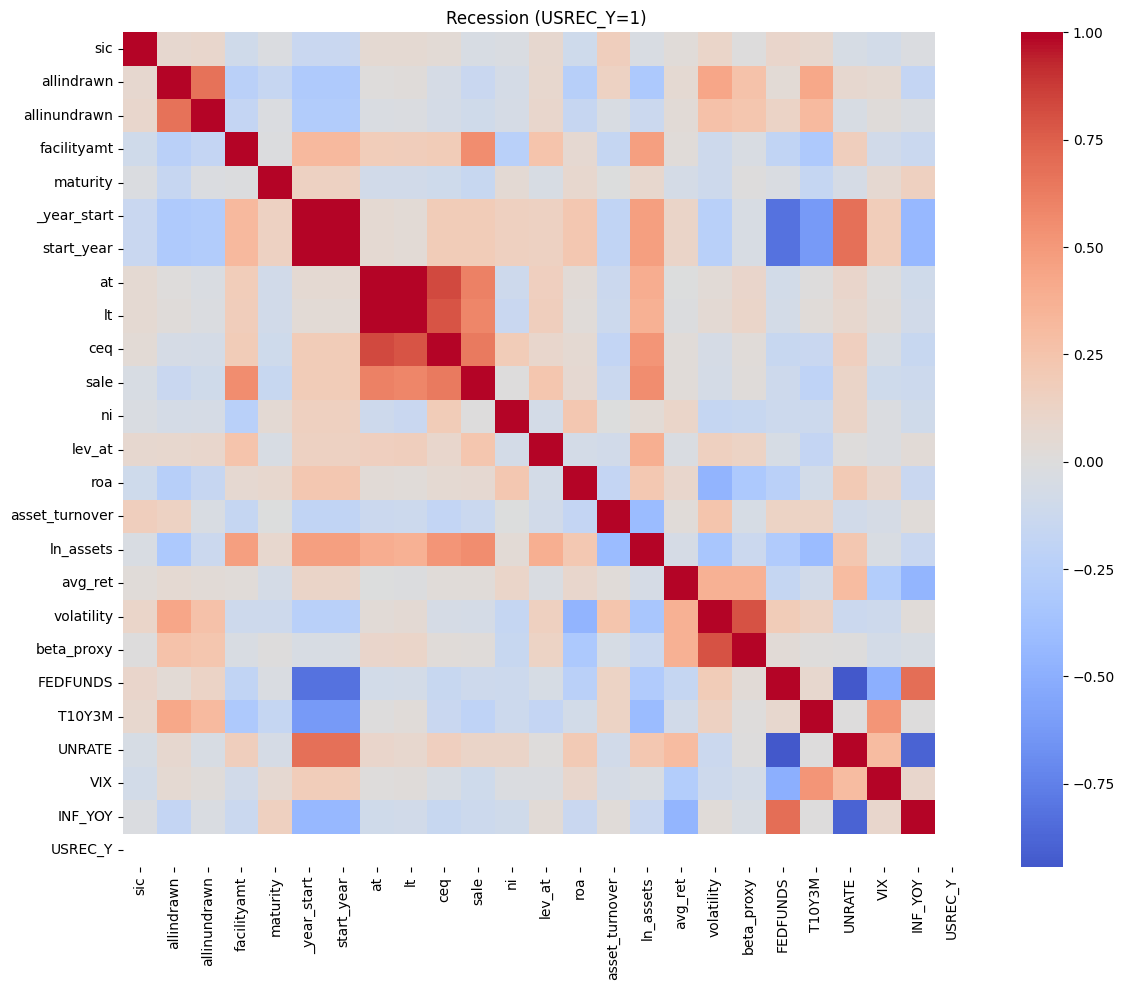

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
sns.heatmap(corr_full, cmap="coolwarm", center=0)
plt.title("Correlation Matrix — Full Sample")
plt.tight_layout()
plt.savefig("corr_full.png", dpi=250)
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(corr_expansion, cmap="coolwarm", center=0)
plt.title("Expansion (USREC_Y=0)")
plt.tight_layout()
plt.savefig("corr_expansion.png", dpi=250)
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(corr_recession, cmap="coolwarm", center=0)
plt.title("Recession (USREC_Y=1)")
plt.tight_layout()
plt.savefig("corr_recession.png", dpi=250)
plt.show()


Number of features: 17
Feature names: ['lev_at', 'roa', 'asset_turnover', 'ln_assets', 'avg_ret', 'volatility', 'beta_proxy', 'facilityamt', 'maturity', 'FEDFUNDS', 'T10Y3M', 'UNRATE', 'VIX', 'INF_YOY', 'USREC_Y', 'industry_bucket', 'secured']

=== Top 15 XGBoost feature importances ===
secured            0.333582
FEDFUNDS           0.125041
UNRATE             0.064640
T10Y3M             0.062992
facilityamt        0.057718
ln_assets          0.044274
maturity           0.042306
volatility         0.040938
USREC_Y            0.039184
INF_YOY            0.033971
industry_bucket    0.032945
roa                0.027958
lev_at             0.022213
VIX                0.020603
asset_turnover     0.020560
dtype: float32


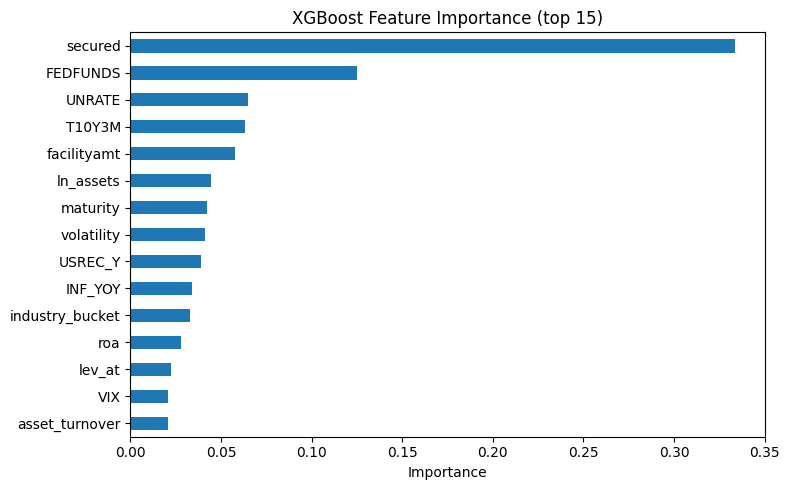


=== Top 15 LightGBM feature importances ===
ln_assets          1663
facilityamt        1662
lev_at             1497
asset_turnover     1254
roa                1254
volatility         1176
beta_proxy          993
maturity            981
avg_ret             888
industry_bucket     665
FEDFUNDS            634
T10Y3M              514
VIX                 486
UNRATE              466
INF_YOY             427
dtype: int32


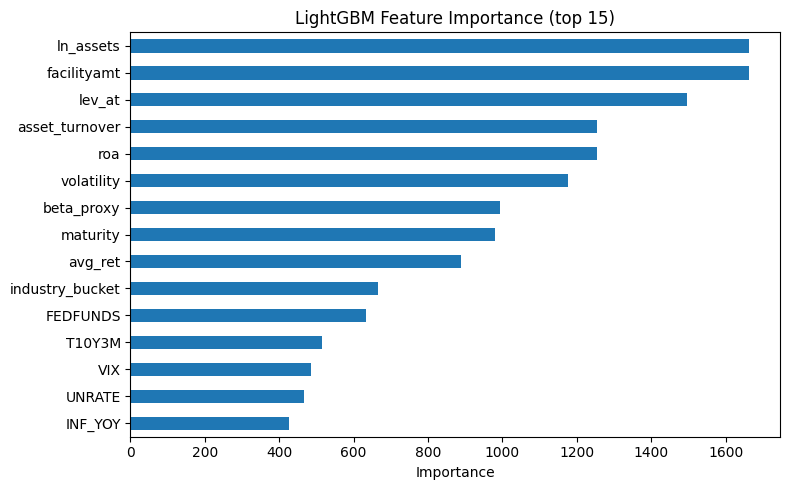


=== Combined importance table (top 20 by mean rank) ===


,XGB_importance,LGB_importance,Mean_rank
ln_assets,0.044274,1663,3.50
facilityamt,0.057718,1662,3.50
FEDFUNDS,0.125041,634,6.50
volatility,0.040938,1176,7.00
maturity,0.042306,981,7.50
lev_at,0.022213,1497,8.00
T10Y3M,0.062992,514,8.00
roa,0.027958,1254,8.25
secured,0.333582,422,8.50
UNRATE,0.064640,466,8.50


In [21]:
# === A: Tree-based Feature Importances (XGBoost & LightGBM) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Get feature names from X_train
feature_names = list(X_train.columns)
print("Number of features:", len(feature_names))
print("Feature names:", feature_names)

# ---------- XGBoost feature importance ----------
try:
    xgb_imp = pd.Series(xgb_reg.feature_importances_, index=feature_names)
    xgb_imp = xgb_imp.sort_values(ascending=False)

    print("\n=== Top 15 XGBoost feature importances ===")
    print(xgb_imp.head(15))

    plt.figure(figsize=(8, 5))
    xgb_imp.head(15).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("XGBoost Feature Importance (top 15)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
except NameError:
    print("\n[XGBoost] xgb_reg not found. Make sure the XGBoost model cell was run.")

# ---------- LightGBM feature importance ----------
try:
    lgb_imp = pd.Series(lgb_model.feature_importances_, index=feature_names)
    lgb_imp = lgb_imp.sort_values(ascending=False)

    print("\n=== Top 15 LightGBM feature importances ===")
    print(lgb_imp.head(15))

    plt.figure(figsize=(8, 5))
    lgb_imp.head(15).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("LightGBM Feature Importance (top 15)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
except NameError:
    print("\n[LightGBM] lgb_model not found. Make sure the LightGBM model cell was run.")

# ---------- Combined importance table (for report) ----------
try:
    imp_df = pd.DataFrame({
        "XGB_importance": xgb_imp,
        "LGB_importance": lgb_imp
    }).fillna(0.0)

    imp_df["Mean_rank"] = (
        imp_df["XGB_importance"].rank(ascending=False) +
        imp_df["LGB_importance"].rank(ascending=False)
    ) / 2.0

    imp_df_sorted = imp_df.sort_values("Mean_rank")
    print("\n=== Combined importance table (top 20 by mean rank) ===")
    display(imp_df_sorted.head(20))
except Exception as e:
    print("\n[Combined importance] Could not build combined table:", e)


In [22]:
# === B0: Install SHAP (run once if needed) ===
!pip install shap


Sampled training shape for SHAP: (3000, 17)
SHAP values shape: (3000, 17)


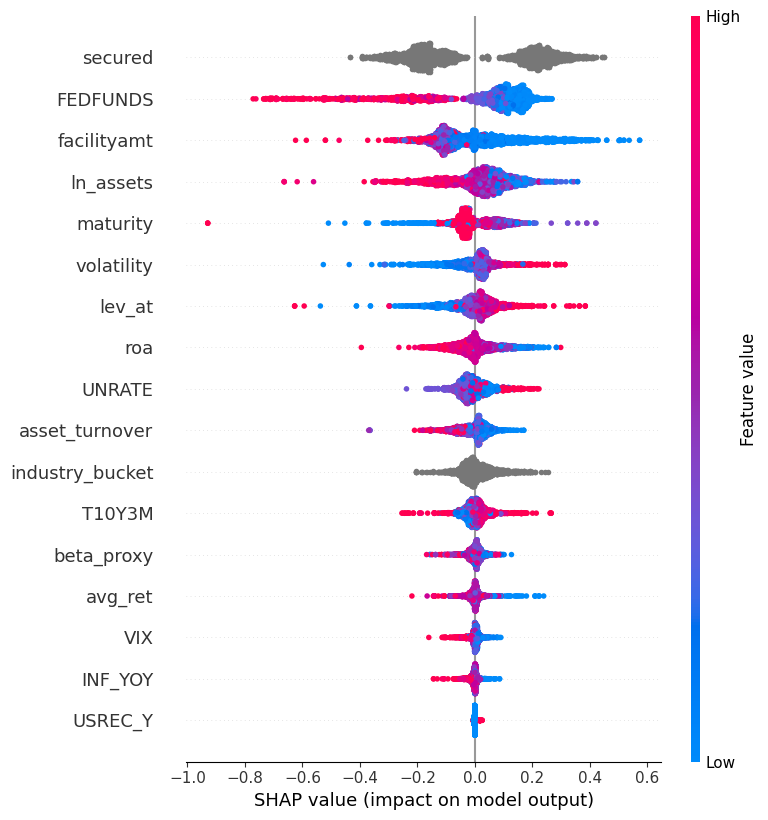

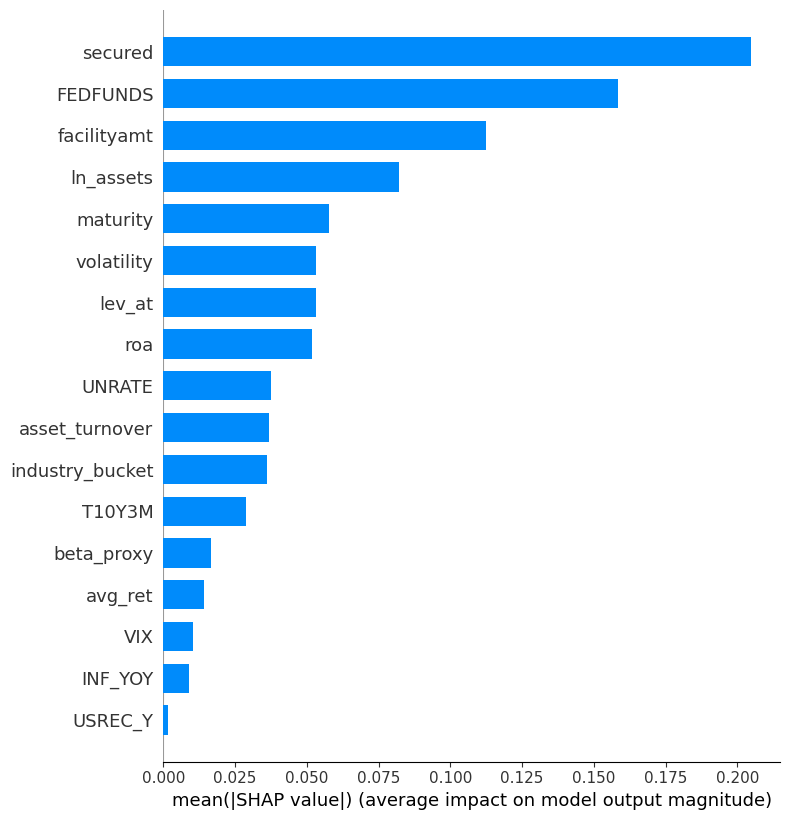

In [23]:
# === B1: SHAP analysis for LightGBM (global feature importance) ===
import shap
import numpy as np

# Ensure JS diagrams work in notebooks (mostly cosmetic)
shap.initjs()

# We'll use a sample of training data for speed
X_train_sample = X_train.sample(n=min(3000, len(X_train)), random_state=42)

print("Sampled training shape for SHAP:", X_train_sample.shape)

# LightGBM must already be fitted as lgb_model
try:
    explainer = shap.TreeExplainer(lgb_model)
    shap_values = explainer.shap_values(X_train_sample)

    # shap_values will be (n_samples, n_features) for regression
    if isinstance(shap_values, list):
        # (usually for multiclass; not our case, but just in case)
        shap_vals_to_use = shap_values[0]
    else:
        shap_vals_to_use = shap_values

    print("SHAP values shape:", np.array(shap_vals_to_use).shape)

    # --- SHAP summary plot (beeswarm) ---
    shap.summary_plot(shap_vals_to_use, X_train_sample, show=True)

    # --- SHAP bar plot (mean |SHAP|) ---
    shap.summary_plot(shap_vals_to_use, X_train_sample, plot_type="bar", show=True)

except NameError:
    print("\n[SHAP] lgb_model or X_train not found. Make sure training cell was run.")


In [24]:
# === B2: Build SHAP importance table (for LaTeX/report) ===
import pandas as pd
import numpy as np

# Convert to numpy in case it's a list
if isinstance(shap_vals_to_use, list):
    shap_array = np.array(shap_vals_to_use[0])
else:
    shap_array = np.array(shap_vals_to_use)

shap_importance = np.abs(shap_array).mean(axis=0)
shap_imp_series = pd.Series(shap_importance, index=X_train_sample.columns)
shap_imp_series = shap_imp_series.sort_values(ascending=False)

shap_imp_df = pd.DataFrame({
    "SHAP_mean_abs": shap_imp_series,
})

print("\n=== Top 20 features by mean |SHAP| (LightGBM) ===")
display(shap_imp_df.head(20))



=== Top 20 features by mean |SHAP| (LightGBM) ===


,SHAP_mean_abs
secured,0.204577
FEDFUNDS,0.158248
facilityamt,0.112577
ln_assets,0.082280
maturity,0.057691
volatility,0.053367
lev_at,0.053193
roa,0.051642
UNRATE,0.037678
asset_turnover,0.036757
